# Part 3: Prediction

In [1]:
import mlrun
import mlrun.feature_store as fstore

In [2]:
import pandas as pd

In [3]:
project_name = 'fraud-predict-demo'

In [4]:
project  = mlrun.get_or_create_project(project_name,'./',user_project=True)

> 2022-08-01 07:50:46,231 [info] loaded project fraud-predict-demo from MLRun DB


In [5]:
data_df = pd.read_csv('./fraud_data.csv')

Now we want to add two steps to the feature set:

1. prep_event - that will prepare the event to the prediction
2. ClassifierModel class - that load the model file and excute the prediction

Those steps will allow us to make a predicition and ingestion at the same time

In [6]:
# mlrun: start-code

In [7]:
def create_labels(event):
    event['label'] = event["fraud"]
    return event

In [8]:
def prep_event(event):
    # list of features that need to be deleted fot the prediction, same as the features we does not defined in the feature vector plus the label feature
    feature_to_delete = ['es_contents_count_14d','age_mapped','age','gender_E','gender_U','zipcodeOri','zipMerchant','category_es_transportation',
                         'category_es_health',
                          'category_es_otherservices',
                          'category_es_food',
                          'category_es_hotelservices',
                          'category_es_barsandrestaurants',
                          'category_es_tech',
                          'category_es_sportsandtoys',
                          'category_es_wellnessandbeauty',
                          'category_es_hyper',
                          'category_es_fashion',
                          'category_es_home',
                          'category_es_contents',
                          'category_es_travel',
                          'category_es_leisure',
                          'fraud',
                          'timestamp',
                          'source',
                          'target',
                          'device',
                          'label']
    for key in feature_to_delete:
        event.pop(key)
    int_feather_values=[]
    for key in event:
        if type(event[key]) in [int,bool,float]:
            int_feather_values.append(event[key])
    event = {'inputs':[int_feather_values]}
    return event

In [9]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [10]:
# mlrun: end-code

In [11]:
fs_predict = fstore.get_feature_set('transactions',project=project.name)

In [12]:
fs_predict.to_dataframe()

,timestamp,amount_avg_2h,amount_avg_12h,amount_avg_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_count_2h,amount_count_12h,amount_count_24h,...,amount,fraud,target,device,event_login,event_details_change,event_password_change,timestamp_hour,timestamp_day_of_week,label
source,,,,,,,,,,,,,,,,,,,,,
C792341594,2022-07-26 17:09:57.487,8.62,8.62,8.62,8.62,8.62,8.62,1.0,1.0,1.0,...,8.62,0,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,1,0,0,17,1,0
C792341594,2022-07-26 17:09:57.487,8.62,8.62,8.62,17.24,17.24,17.24,2.0,2.0,2.0,...,8.62,0,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,0,1,0,17,1,0
C792341594,2022-07-26 17:09:57.487,8.62,8.62,8.62,25.86,25.86,25.86,3.0,3.0,3.0,...,8.62,0,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,1,0,0,17,1,0
C792341594,2022-07-26 17:09:57.487,8.62,8.62,8.62,34.48,34.48,34.48,4.0,4.0,4.0,...,8.62,0,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,1,0,0,17,1,0
C792341594,2022-07-26 17:09:57.487,8.62,8.62,8.62,43.10,43.10,43.10,5.0,5.0,5.0,...,8.62,0,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,0,1,0,17,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C841956493,2022-07-26 21:16:40.929,5.30,5.30,5.30,84.80,84.80,84.80,16.0,16.0,16.0,...,5.30,0,M1823072687,c5d5b2df6a9c45938b2142b1890c2697,0,1,0,21,1,0
C841956493,2022-07-26 21:16:40.929,5.30,5.30,5.30,90.10,90.10,90.10,17.0,17.0,17.0,...,5.30,0,M1823072687,c5d5b2df6a9c45938b2142b1890c2697,0,0,1,21,1,0
C841956493,2022-07-26 21:16:40.929,5.30,5.30,5.30,95.40,95.40,95.40,18.0,18.0,18.0,...,5.30,0,M1823072687,c5d5b2df6a9c45938b2142b1890c2697,1,0,0,21,1,0


Adding the two prediction steps to the feature set (prep_event, model-serving).

It is Important to add the ``after`` and the ``before`` flags to define where to add this steps in the serving graph


In [13]:
fs_predict.graph.add_step(name='prep_event',handler='prep_event',after='create_labels')
fs_predict.graph.add_step(name='model-serving',class_name='ClassifierModel',model_path=project.get_artifact_uri(f"training_model"),after='prep_event').respond()

Becuase we wanted to make a ingestion and prediction parallelly we define that the ingestion of the feature set will occurs after the create label steps

In [14]:
fs_predict.set_targets(default_final_step='create_labels')

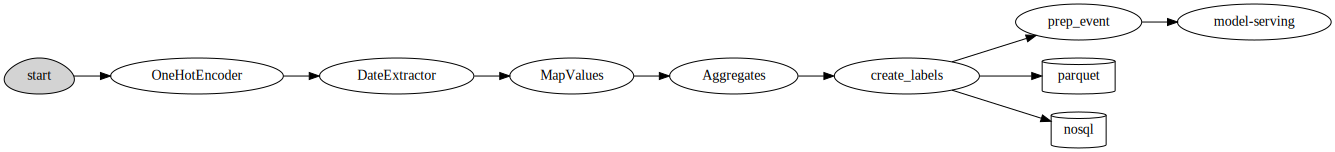

In [15]:
fs_predict.plot(rankdir="LR", with_targets=True)

You can look at the plot above and see that after the create labels steps the graph ingest the data and at the same time make a prediction

In [16]:
# predict_df = fstore.ingest(fs_predict,data_df[0:1],overwrite=False)

In [17]:
# Creating a MlRun function based on the code above - must for any custome steps ( we have three custome steps)

serving_fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun")

For deploy ingestion service you need to use [deploy_ingestion_service](https://docs.mlrun.org/en/latest/api/mlrun.feature_store.html?highlight=deploy_ingestion_service#mlrun.feature_store.deploy_ingestion_service) method.

Start real-time ingestion service using nuclio function

Deploy a real-time function implementing feature ingestion pipeline the source maps to Nuclio event triggers (http, kafka, v3io stream, etc.)

the run_config parameter allow specifying the function and job configuration, see: [RunConfig](https://docs.mlrun.org/en/latest/api/mlrun.feature_store.html?highlight=deploy_ingestion_service#mlrun.feature_store.RunConfig)

For local mode define ``run_config=fstore.RunConfig(local=True)`` 

In [18]:
# Run Local for testing 
serving_fn_local = fstore.deploy_ingestion_service(fs_predict,source=mlrun.datastore.HttpSource(key_field="source",time_field="timestamp"),run_config=fstore.RunConfig(local=True))

> 2022-08-01 07:51:00,202 [info] model model-serving was loaded


In [19]:
inputs={'step': 121,'age': '2','gender': 'M','zipcodeOri': 28007,'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 23.36,
 'fraud': 0,
 'timestamp': '2022-07-27 12:20:36.175',
 'source': 'C1135495199',
 'target': 'M1823072687',
 'device': '944f30cff4cd4693ac4acae782266270',
 'event': 'login'}

In [20]:
serving_fn_local.test('/',inputs)

Input -> [[23.36, 23.36, 23.36, 1.0, 1.0, 1.0, 23.36, 23.36, 23.36, 23.36, 23.36, 23.36, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 121, 1, 0, 23.36, 1, 0, 0, 12, 2]]


X does not have valid feature names, but AdaBoostClassifier was fitted with feature names


{'id': '678371fa3bb4421995330e35bdae703b',
 'model_name': 'model-serving',
 'outputs': [0]}

In [21]:
# Deploy your Feature set for remote ingestion from HTTP source
remote_adress = fstore.deploy_ingestion_service(fs_predict,source=mlrun.datastore.HttpSource(key_field="source",time_field="timestamp"),run_config=fstore.RunConfig(serving_fn))

> 2022-08-01 07:51:00,611 [info] Starting remote function deploy
2022-08-01 07:51:00  (info) Deploying function
2022-08-01 07:51:00  (info) Building
2022-08-01 07:51:00  (info) Staging files and preparing base images
2022-08-01 07:51:00  (info) Building processor image
2022-08-01 07:52:06  (info) Build complete
2022-08-01 07:52:18  (info) Function deploy complete
> 2022-08-01 07:52:18,546 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-predict-demo-shapira-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-predict-demo-shapira-transaction-fraud-fraud-pre-ink9pwof.default-tenant.app.cust-cs-il-3-4-1.iguazio-cd1.com/']}


In [22]:
inputs={'step': 500,'age': '30','gender': 'M','zipcodeOri': 23154,'zipMerchant': 39445,
 'category': 'es_transportation',
 'amount': 50.01,
 'fraud': 0,
 'timestamp': '2022-07-27 15:30:36.175',
 'source': 'C1100495199',
 'target': 'M2503072687',
 'device': '950f20cff4cd4693ac4acae782266270',
 'event': 'login'}

In [23]:
serving_fn.invoke('/',inputs)

> 2022-08-01 07:52:18,749 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-predict-demo-shapira-transaction-fraud.default-tenant.svc.cluster.local:8080/'}


{'id': '84da46b4-d8b1-4dbf-92b2-6f239c102eb9',
 'model_name': 'model-serving',
 'outputs': [0]}

# Done
You now have a feature set that processes predictions while simultaneously ingesting data.